# Structure Optimization

In [1]:
%matplotlib notebook
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import animation

import random
import time

In [2]:
from potentials import gradients
from distances import vectors
from ewald_numpy import Ewald

In [14]:
def grad_Ewald( x, q, boxsz=(0,1), pbc=False ):
    vecs = vectors(x, boxsz)
    E = Ewald(charges=q, boxsize=boxsz, alpha=5, r_cutoff=5, n_max=2, k_cutoff=5)
    return -E.force(x)

def grad_HLC( x, q, boxsize=(0,1), pbc=False ):
    """Sum of Harmonic, LJ and Coulombs gradients"""
    vecs = vectors(x, boxsize, pbc)
    return gradients.harmonic(x, boxsize) + gradients.LJ(vecs) - gradients.coulomb(vecs, q)
    
def descent( x, q, grad, a=1e-4, prec=1e-10, maxst=1e6, k=.1, boxsize=(0, 1), pbc=False ):
    """Gradient Descent
    
    Arguments:
        x    (float): position vectors (dim = n x 3)
        q: charge
        a    (float): 'learning rate' alpha = 1e-4
        prec (float): difference between steps, precision = 1e-10
        maxst  (int): max # of steps, maxst = 1e6
        k: factor harmonic pot
    
    Output:
        x: position array,
        step: # of steps needed to converge"""
    xmin, xmax = boxsize[0], boxsize[1]
    L = xmax - xmin
    x = x[None, :, :]
    step = 0
    f = grad(x[-1], q, pbc=pbc)
    x1 = x[-1] - a * f
    if pbc:
        x1 = x1 + (x1 < xmin) * L
        x1 = x1 - (x1 > xmax) * L  
    while step < maxst and np.linalg.norm(x[-1] - x1) > prec:
        x = np.append(x, x1[None, :, :], axis=0)
        f = grad(x[-1], q, pbc=pbc)
        x1 = x[-1] - a * f
        if pbc:
            x1 = x1 + (x1 < xmin) * L
            x1 = x1 - (x1 > xmax) * L
        step += 1
    return x, step

# 2D case, Harmonic + LJ + Coulomb

In [4]:
def x_init_gen2D(N=3, qfac=7, alternating=False): 
    """Generate initial particle distribution
        N**2 - # of particles
        qfac - 
    
    Output:
        x: position array,
        step: # of steps needed to converge"""
    x, y = np.linspace(-N, N, N), np.linspace(-N, N, N)
    XX, YY = np.meshgrid(x,y)
    if alternating:
        q = np.array([(-1)**i for i in range(N) for j in range(N)])
    else:
        q = np.array([[-1,1][random.randrange(2)] for i in range(N*N)])
    q *= qfac
    x_init = np.array([XX.flatten(),YY.flatten()]).T
    x_init += np.random.uniform(low=-0.5, high=0.5, size=(N**2,2))
    #x_init *= 10
    assert len(x_init) == N**2
    return x_init, q

In [5]:
x_init, q = x_init_gen2D()
print(q)

[-7 -7 -7  7 -7  7  7 -7  7]


In [6]:
print('(# of particles, dimensions): ', x_init.shape)
t0 = time.time()
positions, nsteps = descent(x_init, q, grad_HLC, a=1e-4, prec=1e-5, maxst=40000, k=0.1, pbc=False)
t1 = time.time()
print('# of steps:', nsteps, '| positions.shape:', positions.shape)
print('time elapsed: ', t1 - t0)

(# of particles, dimensions):  (9, 2)
# of steps: 17327 | positions.shape: (17328, 9, 2)
time elapsed:  9.343213081359863


9


<IPython.core.display.Javascript object>


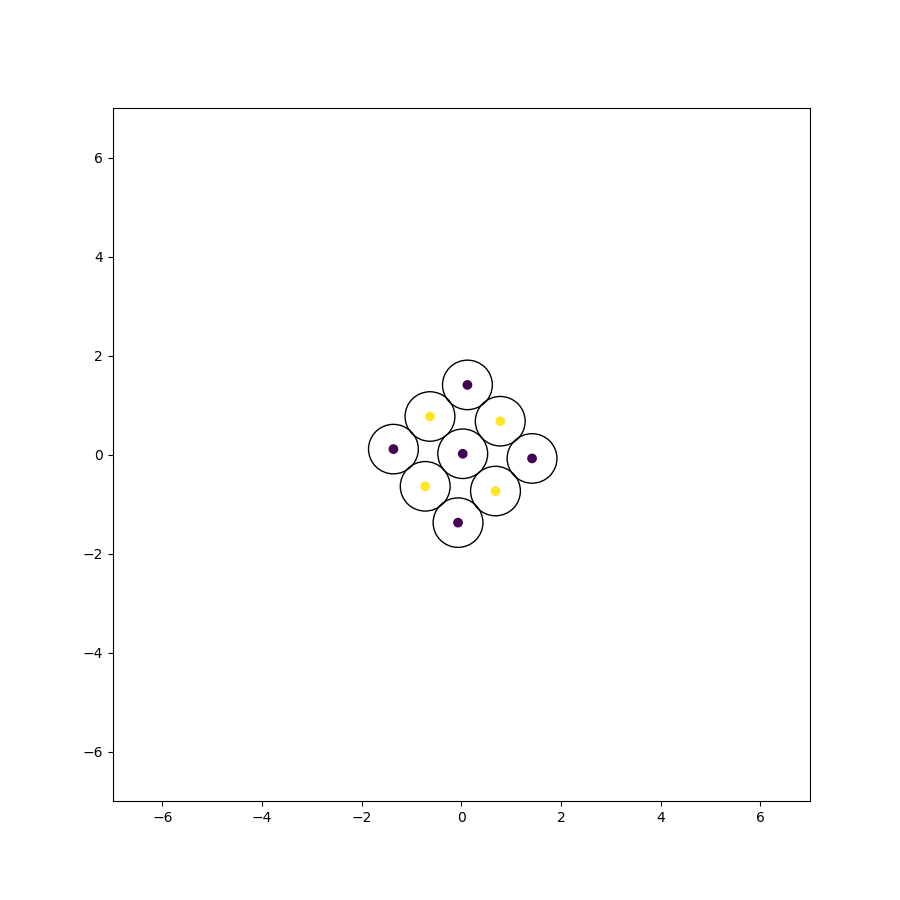

In [7]:
mask = np.count_nonzero(np.linalg.norm(positions[-1], axis=-1) < 10)
print(mask)

fig, ax = plt.subplots(figsize=(9, 9))
colors = np.arange(len(x_init))
scat = ax.scatter(x_init[:,0], x_init[:,1], c=q)
circles = [plt.Circle(r, radius=0.5, fill=False) 
            for i,r in enumerate(x_init)]
for c in circles:
    plt.gca().add_patch(c)
ax.set_xlim(-7, 7)
ax.set_ylim(-7, 7)
def animate(i):
    index = 4*i
    data = positions[index]
    scat.set_offsets(data)
    for i, c in enumerate(circles):
        c.center = data[i]
    return scat
anim = animation.FuncAnimation(fig, animate, interval=1)

In [8]:
def x_init_gen3D(N=3): 
    x = np.linspace(-N, N, N)
    XX, YY, ZZ = np.meshgrid(x,x,x)
    #q = np.array([[-1,1][random.randrange(2)] for i in range(N**3)])
    q = np.array([(-1)**j for i in range(N**2) for j in range(N)]) * 10
    x_init = np.array([XX.flatten(),YY.flatten(),ZZ.flatten()]).T
    x_init += np.random.uniform(low=-0.1, high=0.1, size=(N**3,3))
    #x_init *= 10
    assert len(x_init) == N**3
    return x_init, q

In [9]:
x_init, q = x_init_gen3D(2)
print(x_init.shape)
positions, nsteps = descent(x_init, q, grad_HLC, k=0.1, 
                       a=1e-4, prec=1e-6, maxst=80000)
print('# of steps:', nsteps, '| positions.shape:', positions.shape)

(8, 3)
# of steps: 26180 | positions.shape: (26181, 8, 3)


<IPython.core.display.Javascript object>


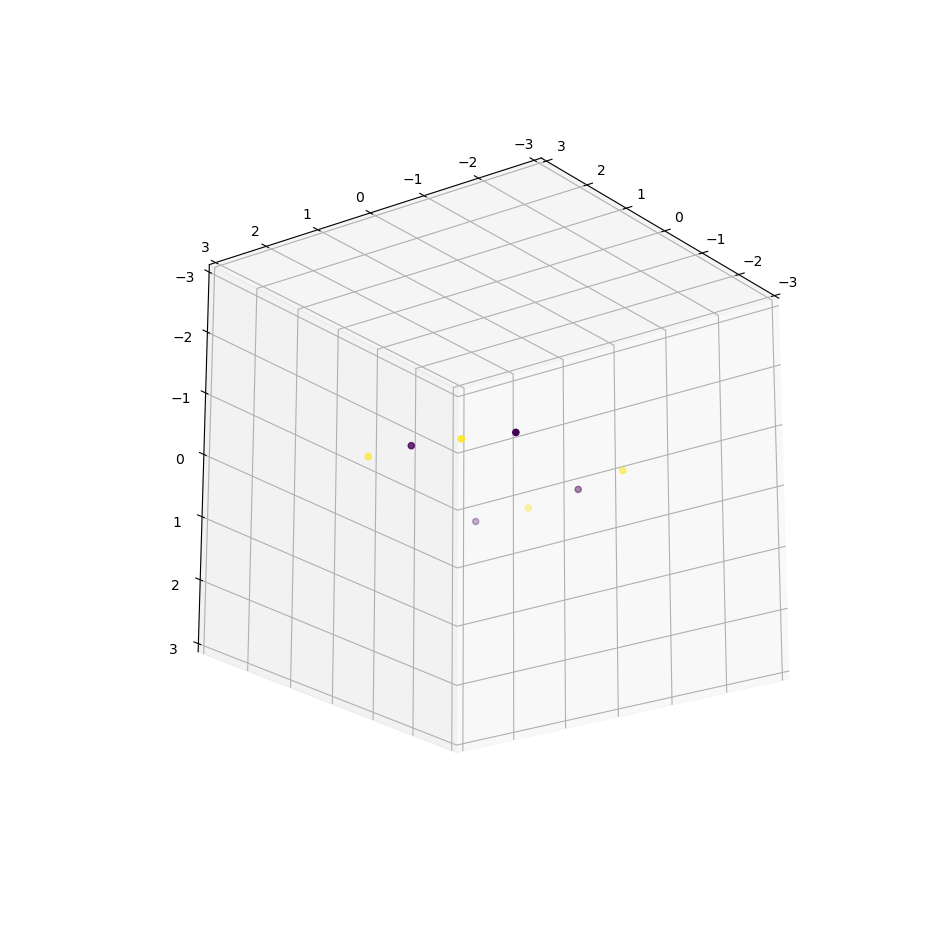

In [10]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(9.5,9.5))
ax = fig.add_subplot(111, projection='3d')
colors = np.arange(len(x_init))
scat = ax.scatter(x_init[:,0], x_init[:,1], x_init[:,2], c=q)
#circles = [plt.Circle(r, radius=0.5, fill=False) 
#            for i,r in enumerate(x_init)]
#for c in circles:
#    plt.gca().add_patch(c)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
def animate(i):
    index = 4*i
    data = positions[index]
    scat._offsets3d=(data[:,0],data[:,1],data[:,2])
    #for i, c in enumerate(circles):
    #    c.center = data[i]
    return scat,

#anim = animation.FuncAnimation(fig, animate, interval=1)
anim = animation.FuncAnimation(fig, animate, interval=20, frames=1050, repeat=False)

# 3D case, Ewald forces

In [11]:
x_init, q = x_init_gen3D(2)
print(x_init.shape)
print(q)

(8, 3)
[ 10 -10  10 -10  10 -10  10 -10]


In [16]:
t0 = time.time()
positions, nsteps = descent(x_init, q, grad_Ewald, a=1e-4, prec=1e-6, maxst=10000)
t1 = time.time()
print('# of steps:', nsteps, '| positions.shape:', positions.shape)
print('time: ', t1 - t0)

# of steps: 10000 | positions.shape: (10001, 8, 3)
time:  53.912556648254395


<IPython.core.display.Javascript object>


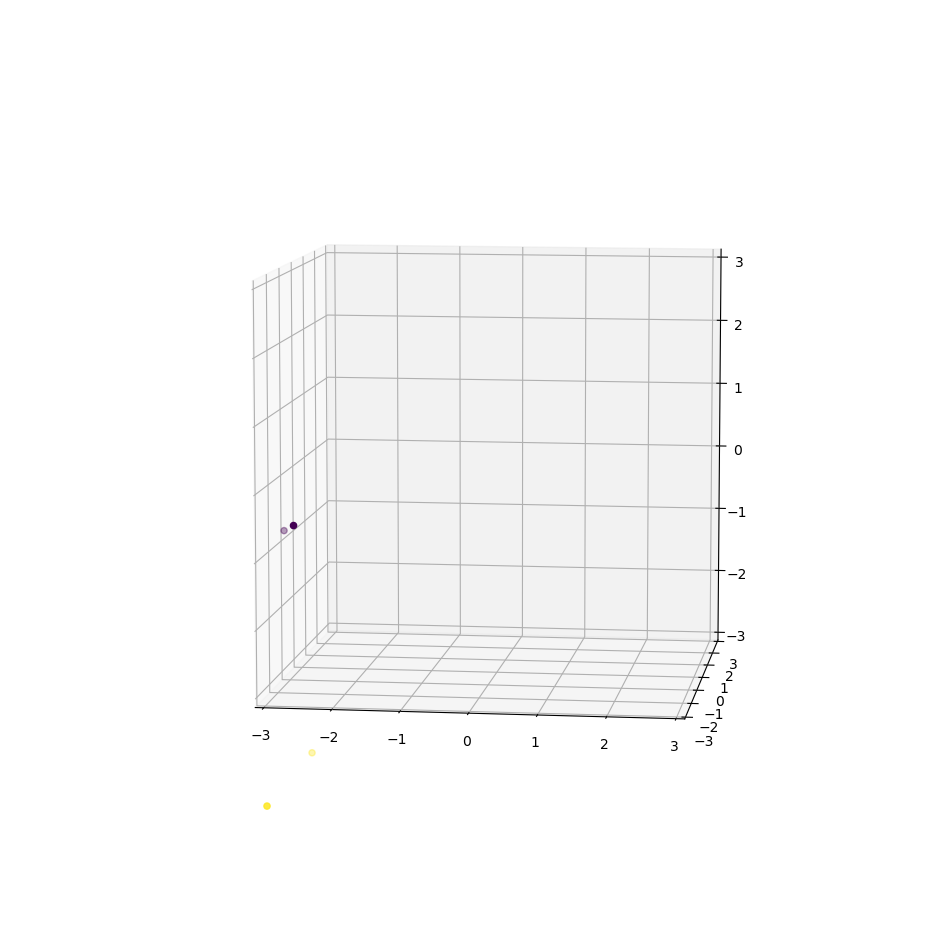

In [17]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(9.5,9.5))
ax = fig.add_subplot(111, projection='3d')
colors = np.arange(len(x_init))
scat = ax.scatter(x_init[:,0], x_init[:,1], x_init[:,2], c=q)
#circles = [plt.Circle(r, radius=0.5, fill=False) 
#            for i,r in enumerate(x_init)]
#for c in circles:
#    plt.gca().add_patch(c)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
def animate(i):
    index = 4*i
    data = positions[index]
    scat._offsets3d=(data[:,0],data[:,1],data[:,2])
    #for i, c in enumerate(circles):
    #    c.center = data[i]
    return scat,


#anim = animation.FuncAnimation(fig, animate, interval=1)
anim = animation.FuncAnimation(fig, animate, interval=20, frames=1050, repeat=False)

In [ ]:
boxsize = (0, 1)
xmin, xmax = boxsize[0], boxsize[1]
L = xmax - xmin
pbc = True
x0 = np.array([[.4, .6], [.1, .8]])
f = np.array([[.5, -.1], [.1, -.7]])
x1 = x0 - f
print(x0)
print(f)
print(x1)
print(x1 < xmin)
print(x1 > xmax)
if pbc:
    x1 = x1 + (x1 < xmin) * L
    x1 = x1 - (x1 > xmax) * L
print(x1)